<a href="https://colab.research.google.com/github/RonnyGuevara/Computer_Graphics/blob/main/TP11/CG11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código HTML

In [ ]:
<doctype html>
<html>
<head>
<title> FCG 2021 - TP5</title>

<!-- estilo-->
<link href="style.css" rel="stylesheet">

<!-- <script src="https://greggman.github.io/webgl-lint/webgl-lint.js" crossorigin></script> -->

<script type="text/javascript" id="includedscript" src="boxdrawer.js"></script>
<script type="text/javascript" id="includedscript" src="lightview.js"></script>
<script type="text/javascript" id="includedscript" src="project5.js"></script>
<script type="text/javascript" id="includedscript" src="ejercicio.js"></script>
<script type="text/javascript" src="objmesh.js"></script>
<!-- <script src="https://greggman.github.io/webgl-lint/webgl-lint.js" crossorigin></script> -->

</head>
<body onresize="WindowResize()">
    <!-- canvas (WebGL)-->
    <div id="canvas-div"><canvas id="canvas"></canvas></div><div id="controls-div">
    <!-- menu y controles-->
    <div id="controls">
        <div class="control-group"><canvas id="lightcontrol"></canvas><div id="lightcontrol-label">Dirección de la Luz</div></div>
        <div class="control-group">
            <div class="control"><input id="show-box" name="show-box" type="checkbox" onchange="DrawScene()" checked /><label for="show-box"> Mostrar caja</label></div>
            <div class="control"><input id="show-texture" name="show-texture" type="checkbox" onchange="ShowTexture(this)" checked /><label for="show-texture"> Mostrar textura</label></div>
            <div class="control"><input id="swap-yz" name="swap-yz" type="checkbox" onchange="SwapYZ(this)" /><label for="swap-yz"> Intercambiar Y-Z</label></div>
            <div class="control"><input id="auto-rotate" name="auto-rotate" type="checkbox" onchange="AutoRotate(this)"/><label for="auto-rotate"> Calesita</label></div>
            <div class="control"><input id="rotation-speed" type="range" min="1" max="100" value="50" disabled/></div>
            <div class="control"><span id="shininess-label">Intensidad:</span><span id="shininess-value">1</span><input id="shininess-exp" type="range" min="0" max="100" value="50" oninput="SetShininess(this)"/></div>
        </div>
        <div class="control-group">
            <div class="control">Modelo:<br/><input id="obj" type="file" onchange="LoadObj(this)" accept=".obj"/></div>
            <div class="control">Textura:<br/><input id="texture" type="file" onchange="LoadEnvMap(this)" accept="image/*" webkitdirectory multiple /></div>
        </div>
        <div class="control-group">
            <img id="texture-img" />
            <img id="normal-map-img" />
            <img id="env_mapX" />
            <img id="env_mapX_" />
            <img id="env_mapY" />
            <img id="env_mapY_" />
            <img id="env_mapZ" />
            <img id="env_mapZ_" />
        </div>
    </div>
    </div>
</body>
</html>

#Código JAVA

In [ ]:
// Estructuras globales e inicializaciones
var boxDrawer;          // clase para contener el comportamiento de la caja
var meshDrawer;         // clase para contener el comportamiento de la malla
var canvas, gl;         // canvas y contexto WebGL
var perspectiveMatrix;	// matriz de perspectiva

var obj_loaded = false;

var rotX=0, rotY=0, transZ=3, autorot=0;

// Funcion de inicialización, se llama al cargar la página
function InitWebGL()
{
	// Inicializamos el canvas WebGL
	canvas = document.getElementById("canvas");
	canvas.oncontextmenu = function() {return false;};
	gl = canvas.getContext("webgl", {antialias: false, depth: true});	
	if (!gl) 
	{
		alert("Imposible inicializar WebGL. Tu navegador quizás no lo soporte.");
		return;
	}
	
	// Inicializar color clear
	gl.clearColor(0,0,0,0);
	gl.enable(gl.DEPTH_TEST); // habilitar test de profundidad 
	
	// Inicializar los shaders y buffers para renderizar	
	boxDrawer  = new BoxDrawer("lines");
	meshDrawer = new MeshDrawer();
	
	// Setear el tamaño del viewport
	UpdateCanvasSize();
}

// Funcion para actualizar el tamaño de la ventana cada vez que se hace resize
function UpdateCanvasSize()
{
	// 1. Calculamos el nuevo tamaño del viewport
	canvas.style.width  = "100%";
	canvas.style.height = "100%";

	const pixelRatio = window.devicePixelRatio || 1;
	canvas.width  = pixelRatio * canvas.clientWidth;
	canvas.height = pixelRatio * canvas.clientHeight;

	const width  = (canvas.width  / pixelRatio);
	const height = (canvas.height / pixelRatio);

	canvas.style.width  = width  + 'px';
	canvas.style.height = height + 'px';
	
	// 2. Lo seteamos en el contexto WebGL
	gl.viewport( 0, 0, canvas.width, canvas.height );

	// 3. Cambian las matrices de proyección, hay que actualizarlas
	UpdateProjectionMatrix();
}

// Calcula la matriz de perspectiva (column-major)
function ProjectionMatrix( c, z, fov_angle=60 )
{
	var r = c.width / c.height;
	var n = (z - 1.74);
	const min_n = 0.001;
	if ( n < min_n ) n = min_n;
	var f = (z + 1.74);;
	var fov = 3.145 * fov_angle / 180;
	var s = 1 / Math.tan( fov/2 );
	return [
		s/r, 0, 0, 0,
		0, s, 0, 0,
		0, 0, (n+f)/(f-n), 1,
		0, 0, -2*n*f/(f-n), 0
	];
}

// Devuelve la matriz de perspectiva (column-major)
function UpdateProjectionMatrix()
{
	perspectiveMatrix = ProjectionMatrix( canvas, transZ );
}

// Funcion que reenderiza la escena. 
function DrawScene()
{
	// 1. Obtenemos las matrices de transformación 
	var mv  = GetModelViewMatrix( 0, 0, transZ, rotX, autorot+rotY );
	var mvp = MatrixMult( perspectiveMatrix, mv );

	// 2. Limpiamos la escena
	gl.clear( gl.COLOR_BUFFER_BIT | gl.DEPTH_BUFFER_BIT );
	
	// 3. Le pedimos a cada objeto que se dibuje a si mismo
	var nrmTrans = [ mv[0],mv[1],mv[2], mv[4],mv[5],mv[6], mv[8],mv[9],mv[10] ];
	
	if (obj_loaded)
		meshDrawer.draw( mvp, mv, nrmTrans );
	
	if ( showBox.checked ) {
		boxDrawer.draw( mvp );
	}
}

// Función que compila los shaders que se le pasan por parámetro (vertex & fragment shaders)
// Recibe los strings de cada shader y retorna un programa
function InitShaderProgram( vsSource, fsSource, wgl=gl )
{
	// Función que compila cada shader individualmente
	const vs = CompileShader( wgl.VERTEX_SHADER,   vsSource, wgl );
	const fs = CompileShader( wgl.FRAGMENT_SHADER, fsSource, wgl );

	// Crea y linkea el programa 
	const prog = wgl.createProgram();
	wgl.attachShader(prog, vs);
	wgl.attachShader(prog, fs);
	wgl.linkProgram(prog);

	if (!wgl.getProgramParameter(prog, wgl.LINK_STATUS)) 
	{
		alert('No se pudo inicializar el programa: ' + wgl.getProgramInfoLog(prog));
		return null;
	}
	return prog;
}

// Función para compilar shaders, recibe el tipo (gl.VERTEX_SHADER o gl.FRAGMENT_SHADER)
// y el código en forma de string. Es llamada por InitShaderProgram()
function CompileShader( type, source, wgl=gl )
{
	// Creamos el shader
	const shader = wgl.createShader(type);

	// Lo compilamos
	wgl.shaderSource(shader, source);
	wgl.compileShader(shader);

	// Verificamos si la compilación fue exitosa
	if (!wgl.getShaderParameter( shader, wgl.COMPILE_STATUS) ) 
	{
		alert('Ocurrió un error durante la compilación del shader:' + wgl.getShaderInfoLog(shader));
		wgl.deleteShader(shader);
		return null;
	}

	return shader;
}

// Multiplica 2 matrices y devuelve A*B.
// Los argumentos y el resultado son arreglos que representan matrices en orden column-major
function MatrixMult( A, B )
{
	var C = [];
	for ( var i=0; i<4; ++i ) 
	{
		for ( var j=0; j<4; ++j ) 
		{
			var v = 0;
			for ( var k=0; k<4; ++k ) 
			{
				v += A[j+4*k] * B[k+4*i];
			}

			C.push(v);
		}
	}
	return C;
}

// ======== Funciones para el control de la interfaz ========

var showBox;  // boleano para determinar si se debe o no mostrar la caja

// Al cargar la página
window.onload = function() 
{
	showBox = document.getElementById('show-box');
	InitWebGL();
	
	// Componente para la luz
	lightView = new LightView();

	// Evento de zoom (ruedita)
	canvas.zoom = function( s ) 
	{
		transZ *= s/canvas.height + 1;
		UpdateProjectionMatrix();
		DrawScene();
	}
	canvas.onwheel = function() { canvas.zoom(0.3*event.deltaY); }

	// Evento de click 
	canvas.onmousedown = function() 
	{
		console.log("onmousedown")
		var cx = event.clientX;
		var cy = event.clientY;
		if ( event.ctrlKey ) 
		{
			canvas.onmousemove = function() 
			{
				console.log("onmousemove")
				canvas.zoom(5*(event.clientY - cy));
				cy = event.clientY;
			}
		}
		else 
		{   
			// Si se mueve el mouse, actualizo las matrices de rotación
			canvas.onmousemove = function() 
			{
				console.log("onmousemove")
				rotY += (cx - event.clientX)/canvas.width*5;
				rotX += (cy - event.clientY)/canvas.height*5;
				cx = event.clientX;
				cy = event.clientY;
				UpdateProjectionMatrix();
				DrawScene();
			}
		}
	}

	// Evento soltar el mouse
	canvas.onmouseup = canvas.onmouseleave = function() 
	{
		canvas.onmousemove = null;
	}
	
	SetShininess( document.getElementById('shininess-exp') );
	
	// Dibujo la escena
	DrawScene();
};

// Evento resize
function WindowResize()
{
	UpdateCanvasSize();
	DrawScene();
}

// Control de la calesita de rotación
var timer;
function AutoRotate( param )
{
	// Si hay que girar...
	if ( param.checked ) 
	{
		// Vamos rotando una cantiad constante cada 30 ms
		timer = setInterval( function() 
		{
				var v = document.getElementById('rotation-speed').value;
				autorot += 0.0005 * v;
				if ( autorot > 2*Math.PI ) autorot -= 2*Math.PI;

				// Reenderizamos
				DrawScene();
			}, 30
		);
		document.getElementById('rotation-speed').disabled = false;
	} 
	else 
	{
		clearInterval( timer );
		document.getElementById('rotation-speed').disabled = true;
	}
}

// Control de textura visible
function ShowTexture( param )
{
	meshDrawer.showTexture( param.checked );
	DrawScene();
}

// Control de intercambiar y-z
function SwapYZ( param )
{
	meshDrawer.swapYZ( param.checked );
	DrawScene();
}

// Cargar archivo obj
function LoadObj( param )
{
	if ( param.files && param.files[0] ) 
	{
		var reader = new FileReader();
		reader.onload = function(e) 
		{
			var mesh = new ObjMesh;
			mesh.parse( e.target.result );
			var box = mesh.getBoundingBox();
			var shift = [
				-(box.min[0]+box.max[0])/2,
				-(box.min[1]+box.max[1])/2,
				-(box.min[2]+box.max[2])/2
			];
			var size = [
				(box.max[0]-box.min[0])/2,
				(box.max[1]-box.min[1])/2,
				(box.max[2]-box.min[2])/2
			];
			var maxSize = Math.max( size[0], size[1], size[2] );
			var scale = 1/maxSize;
			mesh.shiftAndScale( shift, scale );
			var buffers = mesh.getVertexBuffers();
			meshDrawer.setMesh( buffers.positionBuffer, buffers.texCoordBuffer, buffers.normalBuffer );
			obj_loaded = true;
			DrawScene();
		}
		reader.readAsText( param.files[0] );
	}
}

// Cargar textura
function LoadEnvMap( param )
{
	imageX = new Image();
	imageX_ = new Image();
	imageY = new Image();
	imageY_ = new Image();
	imageZ = new Image();
	imageZ_ = new Image();

	readerX = new FileReader();
	readerX_ = new FileReader();
	readerY = new FileReader();
	readerY_ = new FileReader();
	readerZ = new FileReader();
	readerZ_ = new FileReader();
	

	for (var f=0; f<param.files.length; f++)
	{
		if (param.files[f].name[0] == ".") continue;

		switch (param.files[f].name.split('.')[0])
		{
			case "x":
				readerX.onload = function(e) 
				{
					imageX.onload = function() { meshDrawer.setEnvMap( imageX, "+x" ); }
					imageX.src = e.target.result;
				};
				readerX.readAsDataURL( param.files[f] );
				break;
			case "x_":
				readerX_.onload = function(e) 
				{
					imageX_.onload = function() { meshDrawer.setEnvMap( imageX_, "-x" ); }
					imageX_.src = e.target.result;
				};
				readerX_.readAsDataURL( param.files[f] );
				break;
			case "y":
				readerY.onload = function(e) 
				{
					imageY.onload = function() { meshDrawer.setEnvMap( imageY, "+y" ); }
					imageY.src = e.target.result;
				};
				readerY.readAsDataURL( param.files[f] );
				break;
			case "y_":
				readerY_.onload = function(e) 
				{
					imageY_.onload = function() { meshDrawer.setEnvMap( imageY_, "-y" ); }
					imageY_.src = e.target.result;
				};
				readerY_.readAsDataURL( param.files[f] );
				break;
			case "z":
				readerZ.onload = function(e) 
				{
					imageZ.onload = function() { meshDrawer.setEnvMap( imageZ, "+z" ); }
					imageZ.src = e.target.result;
				};
				readerZ.readAsDataURL( param.files[f] );
				break;
			case "z_":
				readerZ_.onload = function(e) 
				{
					imageZ_.onload = function() { meshDrawer.setEnvMap( imageZ_, "-z" ); }
					imageZ_.src = e.target.result;
				};
				readerZ_.readAsDataURL( param.files[f] );
				break;
		}

	}
}

// Cargar textura
function LoadNormalMap( param )
{
	if ( param.files && param.files[0] ) 
	{
		var reader = new FileReader();
		reader.onload = function(e) 
		{
			var img = document.getElementById('normal-map-img');
			img.onload = function() 
			{
				meshDrawer.setNormalMap( img );
				DrawScene();
			}
			img.src = e.target.result;
		};
		reader.readAsDataURL( param.files[0] );
	}
}


// Setear Intensidad
function SetShininess( param )
{
	var exp = param.value;
	var s = Math.pow(10,exp/25);
	document.getElementById('shininess-value').innerText = s.toFixed( s < 10 ? 2 : 0 );
	meshDrawer.setShininess(s);
	DrawScene();
}

In [ ]:
class ObjMesh
{
	constructor()
	{
		this.vpos = [];	// posiciones de los vértices
		this.face = [];	// índices de las caras
		this.tpos = [];	// coordenadas de texturas
		this.tang = [];	// vectores tangentes
		this.tfac = [];	// indices de coordenadas de textura por cara
		this.norm = [];	// normales
		this.nfac = [];	// indices de normales por cara
	}
		
	// Abrimos el obj
	load( url )
	{
		var xhttp = new XMLHttpRequest();
		xhttp.onreadystatechange = function() 
		{
			if (this.readyState == 4 && this.status == 200) 
			{
				parse( this.responseText );
			}
		};
		xhttp.open("GET", url, true);
		xhttp.send();
	}
	
	// Leemos el contenido del obj
	parse( objdata )
	{
		var lines = objdata.split('\n');
		for ( var i=0; i<lines.length; ++i ) 
		{
			var line = lines[i].trim();
			var elem = line.split(/\s+/);
			switch ( elem[0][0] ) 
			{
				// Vértices...
				case 'v':
					switch ( elem[0].length ) 
					{
						// Coordenadas de los vértices
						case 1:
							this.vpos.push( [ parseFloat(elem[1]), parseFloat(elem[2]), parseFloat(elem[3]) ] );
							break;
						case 2:
							switch ( elem[0][1] ) 
							{
								// Coordenada de textura
								case 't':
									this.tpos.push( [ parseFloat(elem[1]), parseFloat(elem[2]) ] );
									break;

								// Normal
								case 'n':
									this.norm.push( [ parseFloat(elem[1]), parseFloat(elem[2]), parseFloat(elem[3]) ] );
									break;
							}
							break;
					}
					break;
				// Caras...
				case 'f':
					var f=[], tf=[], nf=[];
					for ( var j=1; j<elem.length; ++j ) 
					{
						var ids = elem[j].split('/');
						var vid = parseInt(ids[0]);

						if ( vid < 0 ) vid = this.vpos.length + vid + 1;
						f.push( vid - 1 );

						if ( ids.length > 1 && ids[1] !== "" ) 
						{
							var tid = parseInt(ids[1]);
							if ( tid < 0 ) tid = this.tpos.length + tid + 1;
							tf.push( tid - 1 );
						}

						if ( ids.length > 2 && ids[2] !== "" ) 
						{
							var nid = parseInt(ids[2]);
							if ( nid < 0 ) nid = this.norm.length + nid + 1;
							nf.push( nid - 1 );
						}
					}
					this.face.push(f);
					if ( tf.length ) this.tfac.push(tf);
					if ( nf.length ) this.nfac.push(nf);
					break;
			}
		}
	}
	
	// Computa y retorna el bounding box del objeto
	getBoundingBox()
	{
		if ( this.vpos.length == 0 ) return null;
		var min = [...this.vpos[0]];
		var max = [...this.vpos[0]];
		for ( var i=1; i<this.vpos.length; ++i ) 
		{
			for ( var j=0; j<3; ++j ) 
			{
				if ( min[j] > this.vpos[i][j] ) min[j] = this.vpos[i][j];
				if ( max[j] < this.vpos[i][j] ) max[j] = this.vpos[i][j];
			}
		}
		return { min: min, max: max };
	}
	
	// Desplazar y escalar
	shiftAndScale( shift, scale )
	{
		for ( var i=0; i<this.vpos.length; ++i ) 
		{
			for ( var j=0; j<3; ++j ) 
			{
				this.vpos[i][j] = (this.vpos[i][j] + shift[j]) * scale;
			}
		}
	}
	
	addTriangleToBuffers( vBuffer, tBuffer, nBuffer, fi, i, j, k )
	{
		var f  = this.face[fi];
		var tf = this.tfac[fi];
		var nf = this.nfac[fi];

		this.addTriangleToBuffer( vBuffer, this.vpos, f, i, j, k, this.addVertToBuffer3 );

		if ( tf ) 
		{
			this.addTriangleToBuffer( tBuffer, this.tpos, tf, i, j, k, this.addVertToBuffer2 );
		}

		if ( nf ) 
		{
			this.addTriangleToBuffer( nBuffer, this.norm, nf, i, j, k, this.addVertToBuffer3 );
		}
	}
	
	addTriangleToBuffer( buffer, v, f, i, j, k, addVert )
	{
		addVert( buffer, v, f, i );
		addVert( buffer, v, f, j );
		addVert( buffer, v, f, k );
	}
	
	addVertToBuffer3( buffer, v, f, i )
	{
		buffer.push( v[f[i]][0] );
		buffer.push( v[f[i]][1] );
		buffer.push( v[f[i]][2] );
	}

	addVertToBuffer2( buffer, v, f, i )
	{
		buffer.push( v[f[i]][0] );
		buffer.push( v[f[i]][1] );
	}

	// Devuelve las posiciones de los vértices, las coordenadas de textura y las normales
	getVertexBuffers()
	{
		// Arreglos para retornar cada uno de los componentes de la malla de triángulos
		var vBuffer = [];
		var tBuffer = [];
		var nBuffer = [];
		
		// Para cada una de las caras...
		for ( var i=0; i<this.face.length; ++i ) 
		{
			// Si la longitud de la cara es menor a 3 lados, la salteamos.
			if ( this.face[i].length < 3 ) continue;
			
			// Agregamos los 3 vértices, sus coordenadas de textura y normales
			this.addTriangleToBuffers( vBuffer, tBuffer, nBuffer, i, 0, 1, 2 );

			// Agregamos las 3 caras
			for ( var j=3; j<this.face[i].length; ++j ) 
			{
				this.addTriangleToBuffers( vBuffer, tBuffer, nBuffer, i, 0, j-1, j );
			}
		}
		
		// Retornamos un objeto con los atributos de la malla
		return { positionBuffer: vBuffer, texCoordBuffer: tBuffer, normalBuffer: nBuffer };
	}
}

In [ ]:
function GetModelViewMatrix( translationX, translationY, translationZ, rotationX, rotationY )
{
	// [COMPLETAR] Modificar el código para formar la matriz de transformación.
	var rx = [
			1,               0,              0,  0,
			0,  Math.cos(rotationX), Math.sin(rotationX),  0,
			0, -Math.sin(rotationX), Math.cos(rotationX),  0,
			0,               0,              0,  1,

		]

	var ry = [
			Math.cos(rotationY),  0,  -Math.sin(rotationY),  0,
			0,               1,                0,  0,
			Math.sin(rotationY),  0,   Math.cos(rotationY),  0,
			0,               0,              0,    1,
		]

	// Matriz de traslación
	var trans = [
		1, 0, 0, 0,
		0, 1, 0, 0,
		0, 0, 1, 0,
		translationX, translationY, translationZ, 1
	];


	var mv = MatrixMult(trans, MatrixMult(ry, rx))
	return mv;
}

// [COMPLETAR] Completar la implementación de esta clase.
class MeshDrawer
{
	// El constructor es donde nos encargamos de realizar las inicializaciones necesarias. 
	constructor()
	{
		// [COMPLETAR] inicializaciones

		// 1. Compilamos el programa de shaders
		this.prog = InitShaderProgram( meshVS, meshFS );
		
		// 2. Obtenemos los IDs de las variables uniformes en los shaders
		this.mvp_loc = gl.getUniformLocation( this.prog, 'mvp' );
		this.mv_loc = gl.getUniformLocation( this.prog, 'mv' );

		this.cube_map = gl.getUniformLocation(this.prog, 'map'); //COMPLETAR
		// COMPLETAR Obtener ids del sampler
		

		// 3. Obtenemos los IDs de los atributos de los vértices en los shaders
		this.pos_loc = gl.getAttribLocation( this.prog, 'pos' );
		this.normal_loc = gl.getAttribLocation( this.prog, 'normal' );

		// 4. Creamos los buffers
		this.pos_buffer = gl.createBuffer();
		this.normal_buffer = gl.createBuffer();
		this.tangent_buffer = gl.createBuffer();

		this.tex_coord_buffer = gl.createBuffer();

		// this.textura = gl.createTexture()
		this.normal_map = gl.createTexture()
		this.env_map = gl.createTexture();

	}

	
	// Esta función se llama cada vez que el usuario carga un nuevo
	// archivo OBJ. En los argumentos de esta función llegan un areglo
	// con las posiciones 3D de los vértices, un arreglo 2D con las
	// coordenadas de textura y las normales correspondientes a cada 
	// vértice. Todos los items en estos arreglos son del tipo float. 
	// Los vértices y normales se componen de a tres elementos 
	// consecutivos en el arreglo vertPos [x0,y0,z0,x1,y1,z1,..] y 
	// normals [n0,n0,n0,n1,n1,n1,...]. De manera similar, las 
	// cooredenadas de textura se componen de a 2 elementos 
	// consecutivos y se  asocian a cada vértice en orden. 
	setMesh( vertPos, texCoords, normals )
	{
		// [COMPLETAR] Actualizar el contenido del buffer de vértices y otros atributos..
		this.numTriangles = vertPos.length / 3 / 3;
		console.log(this.numTriangles)

		// 1. Binding y seteo del buffer de posiciones
		gl.bindBuffer(gl.ARRAY_BUFFER, this.pos_buffer);
		gl.bufferData(gl.ARRAY_BUFFER, new Float32Array(vertPos), gl.STATIC_DRAW);

		// 2. Binding y seteo del buffer de normales	
		gl.bindBuffer(gl.ARRAY_BUFFER, this.normal_buffer);
		gl.bufferData(gl.ARRAY_BUFFER, new Float32Array(normals), gl.STATIC_DRAW);

	}
	

	
	// Esta función se llama para dibujar la malla de triángulos
	// El argumento es la matriz model-view-projection (matrixMVP),
	// la matriz model-view (matrixMV) que es retornada por 
	// GetModelViewProjection y la matriz de transformación de las 
	// normales (matrixNormal) que es la inversa transpuesta de matrixMV
	draw( matrixMVP, matrixMV, matrixNormal )
	{
		// [COMPLETAR] Completar con lo necesario para dibujar la colección de triángulos en WebGL
		
		// 1. Seleccionamos el shader
		gl.useProgram(this.prog)
	
		// 2. Setear uniformes con las matrices de transformaciones
		var ident = [ 1, 0, 0, 0,
					  0, 1, 0, 0,
					  0, 0, 1, 0,
					  0, 0, 0, 1]

		gl.uniformMatrix4fv( this.mvp_loc, false, matrixMVP );
		gl.uniformMatrix4fv( this.mv_loc, false, matrixMV );
		// gl.uniformMatrix4fv( this.m_loc, false, ident );
		// gl.uniformMatrix4fv( this.m_inv_t_loc, false, matrixNormal );

   		// 3. Habilitar atributos: vértices, normales, texturas
		gl.bindBuffer( gl.ARRAY_BUFFER, this.pos_buffer );

		gl.vertexAttribPointer( this.pos_loc, 3, gl.FLOAT, false, 0, 0 );
		gl.enableVertexAttribArray( this.pos_loc );

		// 4 Binding del buffer de color
		gl.bindBuffer( gl.ARRAY_BUFFER, this.normal_buffer );
		
		gl.vertexAttribPointer( this.normal_loc, 3, gl.FLOAT, false, 0, 0 );
		gl.enableVertexAttribArray( this.normal_loc );

		// COMPLETAR Activar la texturas y asignar el texture unit

		gl.drawArrays( gl.TRIANGLES, 0, this.numTriangles * 3 );
	}
	
	// Esta función se llama para setear una textura sobre la malla
	// El argumento es un componente <img> de html que contiene la textura. 
	setTexture( img )
	{
		return;
		console.log(img)
		// [COMPLETAR] Binding de la textura
		gl.bindTexture(gl.TEXTURE_2D, this.textura)

		// Pueden setear la textura utilizando esta función:
		gl.texImage2D( gl.TEXTURE_2D, 0, gl.RGB, gl.RGB, gl.UNSIGNED_BYTE, img );
		gl.generateMipmap(gl.TEXTURE_2D)

		gl.texParameteri(gl.TEXTURE_2D, gl.TEXTURE_MIN_FILTER, gl.NEAREST);
		gl.texParameteri(gl.TEXTURE_2D, gl.TEXTURE_MAG_FILTER, gl.NEAREST);

		gl.texParameteri(gl.TEXTURE_2D, gl.TEXTURE_WRAP_S, gl.REPEAT);
        gl.texParameteri(gl.TEXTURE_2D, gl.TEXTURE_WRAP_T, gl.REPEAT);
       
		gl.useProgram(this.prog)
		gl.uniform1i(this.tex_sampler, 0)
		
	}

	setEnvMap(img, code) 
	{
		
		// COMPLETAR
		
		gl.bindTexture(gl.TEXTURE_CUBE_MAP, this.env_map)
		switch(code){
			case '+x':
				gl.texImage2D(gl.TEXTURE_CUBE_MAP_POSITIVE_X, 0, gl.RGB, gl.RGB,  gl.UNSIGNED_BYTE, img);
				break;
			case '-x':
				gl.texImage2D(gl.TEXTURE_CUBE_MAP_NEGATIVE_X, 0, gl.RGB, gl.RGB, gl.UNSIGNED_BYTE, img);
				break;
			case '-y':
				gl.texImage2D(gl.TEXTURE_CUBE_MAP_NEGATIVE_Y, 0, gl.RGB, gl.RGB, gl.UNSIGNED_BYTE, img);
				break;
			case '+y':
				gl.texImage2D(gl.TEXTURE_CUBE_MAP_POSITIVE_Y, 0, gl.RGB, gl.RGB, gl.UNSIGNED_BYTE, img);
				break;
			case '-z':
				gl.texImage2D(gl.TEXTURE_CUBE_MAP_NEGATIVE_Z, 0, gl.RGB, gl.RGB, gl.UNSIGNED_BYTE, img);
				break;
			case '+z':
				gl.texImage2D(gl.TEXTURE_CUBE_MAP_POSITIVE_Z, 0, gl.RGB, gl.RGB, gl.UNSIGNED_BYTE, img);
				break;
		}
		gl.texParameteri(gl.TEXTURE_CUBE_MAP, gl.TEXTURE_MIN_FILTER, gl.NEAREST);
		gl.texParameteri(gl.TEXTURE_CUBE_MAP, gl.TEXTURE_MAG_FILTER, gl.NEAREST);
		
	

	}

	setNormalMap( img )
	{
		return;
		console.log(img)
		// [COMPLETAR] Binding de la textura
		gl.bindTexture(gl.TEXTURE_2D, this.normal_map)

		// Pueden setear la textura utilizando esta función:
		gl.texImage2D( gl.TEXTURE_2D, 0, gl.RGB, gl.RGB, gl.UNSIGNED_BYTE, img );
		gl.generateMipmap(gl.TEXTURE_2D)

		gl.texParameteri(gl.TEXTURE_2D, gl.TEXTURE_MIN_FILTER, gl.NEAREST);
		gl.texParameteri(gl.TEXTURE_2D, gl.TEXTURE_MAG_FILTER, gl.NEAREST);

		gl.texParameteri(gl.TEXTURE_2D, gl.TEXTURE_WRAP_S, gl.REPEAT);
        gl.texParameteri(gl.TEXTURE_2D, gl.TEXTURE_WRAP_T, gl.REPEAT);

		gl.useProgram(this.prog)
		gl.uniform1i(this.normal_map_sampler, 1)
		
	}
		
        // Esta función se llama cada vez que el usuario cambia el estado del checkbox 'Mostrar textura'
	// El argumento es un boleano que indica si el checkbox está tildado
	showTexture( show )
	{
		// [COMPLETAR] Setear variables uniformes en el fragment shader para indicar si debe o no usar la textura

		// gl.useProgram(this.prog)
		// if (show)
		// 	gl.uniform1i(this.with_tex, 1)
		// else 
		// 	gl.uniform1i(this.with_tex, 0)

		
		
	}
	
	// Este método se llama al actualizar la dirección de la luz desde la interfaz
	setLightDir( x, y, z )
	{		
		// [COMPLETAR] Setear variables uniformes en el fragment shader para especificar la dirección de la luz
		gl.useProgram(this.prog)
		gl.uniform3f(this.light_dir, x, y, z)
	}
		
	// Este método se llama al actualizar el brillo del material 
	setShininess( shininess )
	{		
		// [COMPLETAR] Setear variables uniformes en el fragment shader para especificar el brillo.
		gl.useProgram(this.prog);
		gl.uniform1f(this.alpha, shininess);
	}
}



// [COMPLETAR] Calcular iluminación utilizando Blinn-Phong.

// Recordar que: 
// Si declarás las variables pero no las usás, es como que no las declaraste
// y va a tirar error. Siempre va punto y coma al finalizar la sentencia. 
// Las constantes en punto flotante necesitan ser expresadas como x.y, 
// incluso si son enteros: ejemplo, para 4 escribimos 4.0.

// Vertex Shader
var meshVS = `
	attribute vec3 pos;
	attribute vec3 normal;

	uniform mat4 mvp;
	uniform mat4 mv;

	varying vec3 normal2fs_eye;
	varying vec3 pos2fs_eye;
		

	void main()
	{ 
		normal2fs_eye = (mv * vec4(normal, 0.0)).xyz;
		pos2fs_eye = (mv * vec4(pos, 1.0)).xyz;

		gl_Position = mvp * vec4(pos,1);
	}
`;

// Fragment Shader
// Algunas funciones útiles para escribir este shader:
// Dot product: https://thebookofshaders.com/glossary/?search=dot
// Normalize:   https://thebookofshaders.com/glossary/?search=normalize
// Pow:         https://thebookofshaders.com/glossary/?search=pow
var meshFS = `
	precision mediump float;


	varying vec3 normal2fs_eye;
	varying vec3 pos2fs_eye;
	uniform samplerCube map;

	void main()
	{		
		vec3 N_eye = normalize(normal2fs_eye);
		vec3 V_eye = normalize(pos2fs_eye);
		vec3 R_eye = normalize(reflect(V_eye, N_eye));
		
		vec3 final_color =  textureCube(map, R_eye).rgb;
		
		gl_FragColor = vec4(final_color, 1.0);
	}
`;

In [ ]:
// Controles para la dirección de la luz
var lightView;

class LightView
{
	constructor()
	{
		this.canvas = document.getElementById("lightcontrol");
		this.canvas.oncontextmenu = function() {return false;};

		// Inicializamos el canvas WebGL
		this.gl = this.canvas.getContext("webgl", {antialias: false, depth: true});

		if (!this.gl) 
		{
			alert("Imposible inicializar WebGL. Tu navegador quizás no lo soporte.");
			return;
		}
		
		// Inicialización
		this.gl.clearColor(0.33,0.33,0.33,0);
		this.gl.enable(gl.DEPTH_TEST);
		
		this.rotX = 0;
		this.rotY = 0;
		this.posZ = 5;
		
		this.resCircle = 32;
		this.resArrow = 16;
		this.buffer = this.gl.createBuffer();
		var data = [];

		for ( var i=0; i<=this.resCircle; ++i ) 
		{
			var a = 2 * Math.PI * i / this.resCircle;
			var x = Math.cos(a);
			var y = Math.sin(a);
			data.push( x * .9 );
			data.push( y * .9 );
			data.push( 0 );
			data.push( x );
			data.push( y );
			data.push( 0 );
		}

		for ( var i=0; i<=this.resCircle; ++i ) 
		{
			var a = 2 * Math.PI * i / this.resCircle;
			var x = Math.cos(a);
			var y = Math.sin(a);
			data.push( x );
			data.push( y );
			data.push( -.05 );
			data.push( x );
			data.push( y );
			data.push( 0.05 );
		}

		for ( var i=0; i<=this.resArrow; ++i ) 
		{
			var a = 2 * Math.PI * i / this.resArrow;
			var x = Math.cos(a) * .07;
			var y = Math.sin(a) * .07;
			data.push( x );
			data.push( y );
			data.push( -1 );
			data.push( x );
			data.push( y );
			data.push( 0 );
		}

		data.push( 0 );
		data.push( 0 );
		data.push( -1.2 );

		for ( var i=0; i<=this.resArrow; ++i ) 
		{
			var a = 2 * Math.PI * i / this.resArrow;
			var x = Math.cos(a) * .15;
			var y = Math.sin(a) * .15;
			data.push( x );
			data.push( y );
			data.push( -0.9 );
		}

		this.gl.bindBuffer(this.gl.ARRAY_BUFFER, this.buffer);
		this.gl.bufferData(this.gl.ARRAY_BUFFER, new Float32Array(data), this.gl.STATIC_DRAW);
		
		//Viewport size
		this.canvas.style.width  = "";
		this.canvas.style.height = "";

		const pixelRatio = window.devicePixelRatio || 1;
		this.canvas.width  = pixelRatio * this.canvas.clientWidth;
		this.canvas.height = pixelRatio * this.canvas.clientHeight;

		const width  = (this.canvas.width  / pixelRatio);
		const height = (this.canvas.height / pixelRatio);

		this.canvas.style.width  = width  + 'px';
		this.canvas.style.height = height + 'px';

		this.gl.viewport( 0, 0, this.canvas.width, this.canvas.height );
		this.proj = ProjectionMatrix( this.canvas, this.posZ, 30 );
		
		// Compilamos los shaders
		this.prog = InitShaderProgram( lightViewVS, lightViewFS, this.gl );

		this.mvp = this.gl.getUniformLocation( this.prog, 'mvp' );
		this.clr1 = this.gl.getUniformLocation( this.prog, 'clr1' );
		this.clr2 = this.gl.getUniformLocation( this.prog, 'clr2' );
		this.vertPos = this.gl.getAttribLocation( this.prog, 'pos' );
		
		// Dibujamos
		this.draw();
		this.updateLightDir();
		
		// Evento de click
		this.canvas.onmousedown = function() 
		{
			var cx = event.clientX;
			var cy = event.clientY;
			lightView.canvas.onmousemove = function() 
			{
				lightView.rotY += (cx - event.clientX)/lightView.canvas.width*5;
				lightView.rotX += (cy - event.clientY)/lightView.canvas.height*5;

				cx = event.clientX;
				cy = event.clientY;

				lightView.draw();
				lightView.updateLightDir();
			}
		}
		
		this.canvas.onmouseup = this.canvas.onmouseleave = function() 
		{
			lightView.canvas.onmousemove = null;
		}
	}
	
	updateLightDir()
	{
		var cy = Math.cos( this.rotY );
		var sy = Math.sin( this.rotY );
		var cx = Math.cos( this.rotX );
		var sx = Math.sin( this.rotX );
		meshDrawer.setLightDir( -sy, cy*sx, -cy*cx );
		DrawScene();
	}
	
	draw()
	{
		// Limpiamos la pantalla
		this.gl.clear( this.gl.COLOR_BUFFER_BIT | this.gl.DEPTH_BUFFER_BIT );
		
		this.gl.bindBuffer( this.gl.ARRAY_BUFFER, this.buffer );
		this.gl.vertexAttribPointer( this.vertPos, 3, this.gl.FLOAT, false, 0, 0 );
		this.gl.enableVertexAttribArray( this.vertPos );

		this.gl.useProgram( this.prog );
		var mvp = MatrixMult( this.proj, [ 1,0,0,0, 0,1,0,0, 0,0,1,0, 0,0,this.posZ,1 ] );
		this.gl.uniformMatrix4fv( this.mvp, false, mvp );
		this.gl.uniform3f( this.clr1, 0.6,0.6,0.6 );
		this.gl.uniform3f( this.clr2, 0,0,0 );
		this.gl.drawArrays( this.gl.TRIANGLE_STRIP, 0, this.resCircle*2+2 );

		var mv  = GetModelViewMatrix( 0, 0, this.posZ, this.rotX, this.rotY );
		var mvp = MatrixMult( this.proj, mv );
		this.gl.uniformMatrix4fv( this.mvp, false, mvp );
		this.gl.uniform3f( this.clr1, 1,1,1 );
		this.gl.drawArrays( this.gl.TRIANGLE_STRIP, 0, this.resCircle*2+2 );
		this.gl.drawArrays( this.gl.TRIANGLE_STRIP, this.resCircle*2+2, this.resCircle*2+2 );
		this.gl.uniform3f( this.clr1, 0,0,0 );
		this.gl.uniform3f( this.clr2, 1,1,1 );
		this.gl.drawArrays( this.gl.TRIANGLE_STRIP, this.resCircle*4+4, this.resArrow*2+2 );
		this.gl.drawArrays( this.gl.TRIANGLE_FAN, this.resCircle*4+4 + this.resArrow*2+2, this.resArrow+2 );
	}
}

// Vertex shader
const lightViewVS = `
	attribute vec3 pos;
	uniform mat4 mvp;
	
	void main()
	{
		gl_Position = mvp * vec4(pos,1);
	}
`;

// Fragment shader
var lightViewFS = `
	precision mediump float;
	uniform vec3 clr1;
	uniform vec3 clr2;
	void main()
	{
		gl_FragColor = gl_FrontFacing ? vec4(clr1,1) : vec4(clr2,1);
	}
`;

In [ ]:
// Clase que dibuja la caja alrededor de la escena
class BoxDrawer 
{
	constructor(mode)
	{
		this.mode = mode // "lines" o "polygon"

		// 1. Compilamos el programa de shaders
		this.prog = InitShaderProgram( boxVS, boxFS );
		
		// 2. Obtenemos los IDs de las variables uniformes en los shaders
		this.mvp = gl.getUniformLocation( this.prog, 'mvp' );
		
		// 3. Obtenemos los IDs de los atributos de los vértices en los shaders
		this.vertPos = gl.getAttribLocation( this.prog, 'pos' );
		
		// 4. Creamos el buffer para los vertices				
		this.posbuffer = gl.createBuffer();

		// 8 caras del cubo unitario
		this.pos = [
			-1, -1, -1,
			-1, -1,  1,
			-1,  1, -1,
			-1,  1,  1,
			 1, -1, -1,
			 1, -1,  1,
			 1,  1, -1,
			 1,  1,  1 ];
		gl.bindBuffer(gl.ARRAY_BUFFER, this.posbuffer);
		gl.bufferData(gl.ARRAY_BUFFER, new Float32Array(this.pos), gl.STATIC_DRAW);

		// Conectividad de las lineas
		this.indicesbuffer = gl.createBuffer();

		if (this.mode == "lines") 
			this.indices = [
				0,1,   1,3,   3,2,   2,0,
				4,5,   5,7,   7,6,   6,4,
				0,4,   1,5,   3,7,   2,6 
			];
		else 
			this.indices = [
				1,0,4,  1,4,5,
				3,6,2,  3,7,6,
				3,2,0,  3,0,1,
				4,6,7,  5,4,7,
				0,2,4,  4,2,6,
				1,5,7,  7,3,1
			];	
				

		gl.bindBuffer(gl.ELEMENT_ARRAY_BUFFER, this.indicesbuffer);
		gl.bufferData(gl.ELEMENT_ARRAY_BUFFER, new Uint8Array(this.indices), gl.STATIC_DRAW);
	}

	// Esta función se llama para dibujar la caja
	draw( trans )
	{
		// 1. Seleccionamos el shader
		gl.useProgram( this.prog );
		

		// 2. Setear matriz de transformacion
		gl.uniformMatrix4fv( this.mvp, false, trans );

		 // 3.Binding del buffer de posiciones
		gl.bindBuffer( gl.ARRAY_BUFFER, this.posbuffer );

		// 4. Habilitamos el atributo 
		gl.vertexAttribPointer( this.vertPos, 3, gl.FLOAT, false, 0, 0 );
		gl.enableVertexAttribArray( this.vertPos );

		gl.bindBuffer( gl.ELEMENT_ARRAY_BUFFER, this.indicesbuffer );

		// 5. Dibujamos
		// gl.disable(gl.CULL_FACE);
		if (this.mode == "lines") 
			gl.drawElements( gl.LINES, 24, gl.UNSIGNED_BYTE, 0 );
		else 
			gl.drawElements( gl.TRIANGLES, 36, gl.UNSIGNED_BYTE, 0 );	
		
		// gl.enable(gl.CULL_FACE);
	}
}

// Vertex shader 
var boxVS = `
	attribute vec3 pos;
	uniform mat4 mvp;
	void main()
	{
		gl_Position = mvp * vec4(pos,1);
	}
`;

// Fragment shader 
var boxFS = `
	precision mediump float;
	void main()
	{
		gl_FragColor = vec4(1,1,1,1);
	}
`;

#Resultado

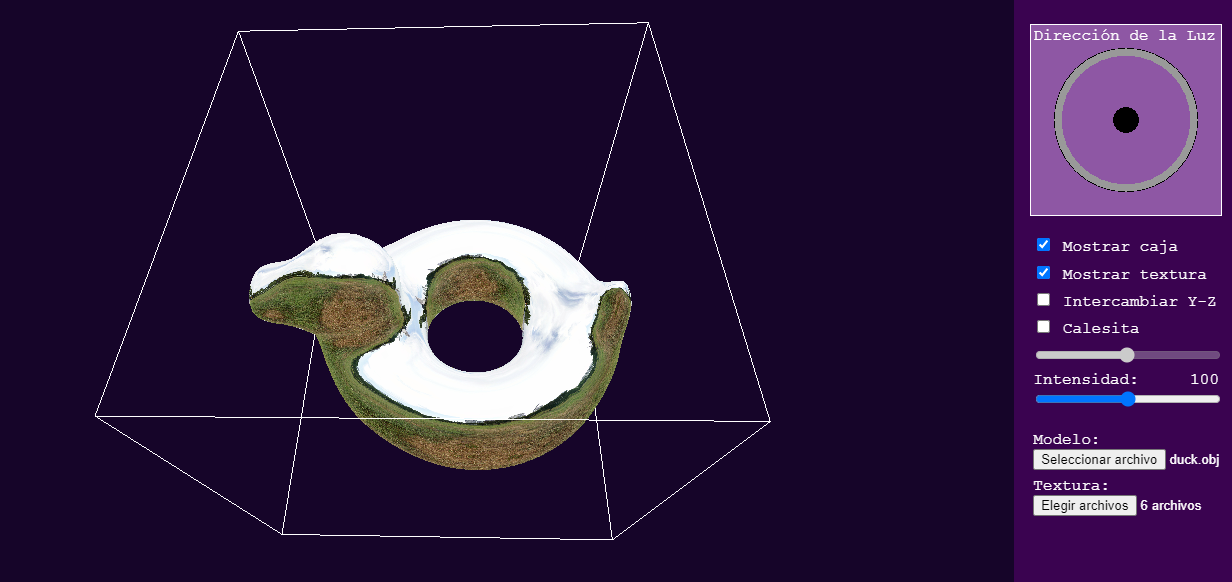

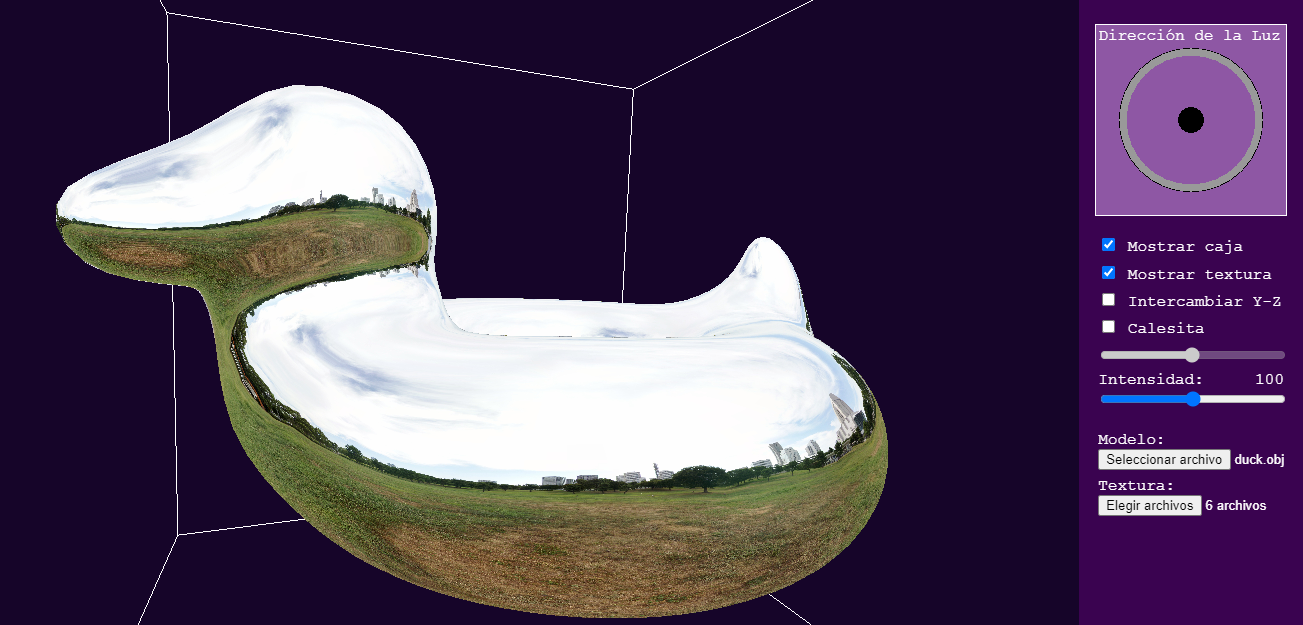

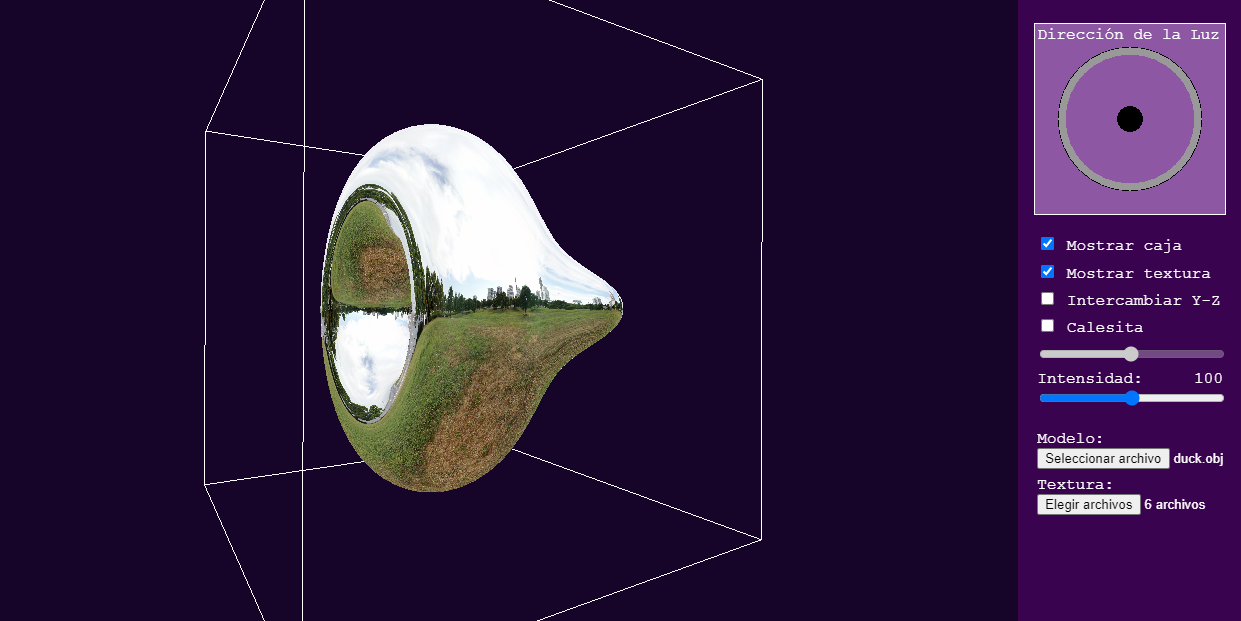